In [1]:
import pandas as pd

In [2]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df=Train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')


## 99% training

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Training and Evaluation
# -----------------------------
def train_rf_model(train_df, test_size=0.01, random_state=42):
    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    # ✅ Using best hyperparameters from Optuna
    model = RandomForestClassifier(
        n_estimators=195,
        max_depth=22,
        min_samples_split=4,
        min_samples_leaf=1,
        random_state=random_state,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return model

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    folder = "/Users/manyamittal/Downloads"
    filename = f"{folder}/predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_2504\1561492193.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


✅ Accuracy: 0.8232

Classification Report:
                          precision    recall  f1-score   support

             functional       0.81      0.92      0.86       323
functional needs repair       0.59      0.30      0.40        43
         non functional       0.88      0.79      0.83       228

               accuracy                           0.82       594
              macro avg       0.76      0.67      0.70       594
           weighted avg       0.82      0.82      0.81       594



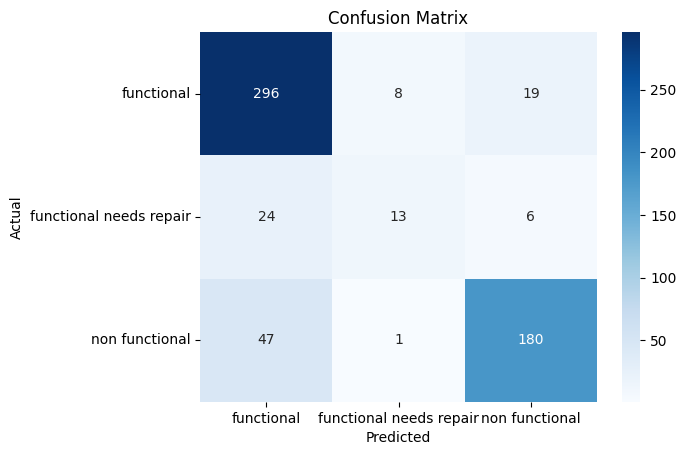

In [19]:
model = train_rf_model(df)

## optuna for 99%training proportion

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import optuna

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Define a function to map each month to its ordinal value
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Building with Optuna
# -----------------------------
df = clean_encode(df, is_train=True)
y = df['status_group']
X = df.drop(columns=['status_group'])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

    # Train the model
    rf.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

# Train the final model with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the final model
y_pred = best_rf.predict(X_test)
print('Final model accuracy:', accuracy_score(y_test, y_pred))

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{folder}/predict_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


[I 2025-05-15 07:41:28,881] A new study created in memory with name: no-name-a81206a5-18ba-479a-8f9f-9a2a5d1cb2b7
[I 2025-05-15 07:41:33,555] Trial 0 finished with value: 0.6632996632996633 and parameters: {'n_estimators': 124, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.6632996632996633.
[I 2025-05-15 07:41:42,041] Trial 1 finished with value: 0.696969696969697 and parameters: {'n_estimators': 169, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.696969696969697.
[I 2025-05-15 07:41:45,577] Trial 2 finished with value: 0.6599326599326599 and parameters: {'n_estimators': 133, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.696969696969697.
[I 2025-05-15 07:41:49,334] Trial 3 finished with value: 0.7609427609427609 and parameters: {'n_estimators': 39, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.7

Best hyperparameters: {'n_estimators': 190, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 2}
Final model accuracy: 0.8159090909090909


In [19]:
X# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

# Train the final model with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate the final model
y_pred = best_rf.predict(X_test)
print('Final model accuracy 0.2:', accuracy_score(y_test, y_pred))

print("----------------------------\n")

# Print the best hyperparameters

categorical_cols = []
encoders = {}
# Train the final model with the best hyperparameters
best_rf_0005 = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)
best_rf_0005.fit(X_train, y_train)

# Evaluate the final model
y_pred = best_rf_0005.predict(X_test)
print('Final model accuracy for 0.005:', accuracy_score(y_test, y_pred))

Best hyperparameters: {'n_estimators': 190, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 2}
Final model accuracy 0.2: 0.8159090909090909
----------------------------

Final model accuracy for 0.005: 0.8316498316498316


In [20]:
test_set_values = clean_encode(test_set_values, is_train=True)

import os
import datetime
import pandas as pd

def predict_test_set(model, test_df):
    # Path to your project folder
    folder = r"C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project"

    # Make sure folder exists
    os.makedirs(folder, exist_ok=True)

    # Clean and encode test data
    test_df_cleaned = clean_encode(test_df, is_train=False)

    # Make predictions
    predictions = model.predict(test_df_cleaned)

    # Create result DataFrame
    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    # Save with timestamped filename
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = os.path.join(folder, f"chitwan_{timestamp}.csv")
    result_df.to_csv(filename, index=False)

    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")
    return result_df


predict_test_set(best_rf_0005, test_set_values)

✅ Saved 14850 predictions to C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\chitwan_2025-05-15_09-49-48.csv


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
